In [1]:
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
from geopy.distance import geodesic, lonlat
import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
file_path1 = '/Users/yokij/Desktop/Capstone/NYC/NYPD_Complaint_Data_Current__Year_To_Date.csv'
data1 = pd.read_csv(file_path1, low_memory=False)
data1 = data1.drop(columns=['New Georeferenced Column'])
data1['CMPLNT_FR_DT'] = pd.to_datetime(data1['CMPLNT_FR_DT'], errors='coerce')
data1 = data1.sort_values(by='CMPLNT_FR_DT', ascending=True)
data1 = data1[(data1['CMPLNT_FR_DT'] >= pd.Timestamp('2023-01-01')) & (data1['CMPLNT_FR_DT'] <= pd.Timestamp('2023-05-31'))]

In [3]:
file_path2 = '/Users/yokij/Desktop/Capstone/NYC/NYPD_Complaint_Data_Historic.csv'
data2 = pd.read_csv(file_path2, low_memory=False)
data2['CMPLNT_FR_DT'] = pd.to_datetime(data2['CMPLNT_FR_DT'], errors='coerce')
data2 = data2.sort_values(by='CMPLNT_FR_DT', ascending=True)
data2 = data2[(data2['CMPLNT_FR_DT'] >= pd.Timestamp('2018-01-01')) & (data2['CMPLNT_FR_DT'] <= pd.Timestamp('2022-12-31'))]

In [4]:
df = pd.concat([data1, data2])

In [5]:
#delete data if its category is NaN
df = df[df['KY_CD'].notna()] #KY_CD is more general than PD_CD
df = df[df['LAW_CAT_CD'].notna()] #This records three categories(felony,misdemeanor and violation)
df = df[df['Lat_Lon'].notna()]

In [6]:
df.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,SUSP_SEX,TRANSIT_DISTRICT,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
405841,261253580,102.0,QUEENS,2023-01-01,22:00:00,01/02/2023,06:20:00,COMPLETED,(null),NaN,...,U,NaN,18-24,ASIAN / PACIFIC ISLANDER,M,1030707.0,190546.0,40.689560,-73.832478,"(40.68956, -73.832478)"
244547,261208845,69.0,BROOKLYN,2023-01-01,18:55:00,01/01/2023,19:02:00,COMPLETED,(null),NaN,...,M,NaN,25-44,BLACK,F,1013831.0,169688.0,40.632382,-73.893422,"(40.632382, -73.893422)"
295876,261291509,61.0,BROOKLYN,2023-01-01,16:28:00,01/01/2023,16:30:00,COMPLETED,(null),NaN,...,F,NaN,45-64,WHITE,F,997560.0,158908.0,40.602832,-73.952065,"(40.602832, -73.952065)"
354453,261370802,44.0,BRONX,2023-01-01,23:30:00,01/01/2023,23:35:00,COMPLETED,(null),NaN,...,M,NaN,25-44,WHITE,M,1006250.0,245145.0,40.839516,-73.920489,"(40.839516, -73.920489)"
338175,261199165,105.0,QUEENS,2023-01-01,13:57:00,01/01/2023,14:10:00,COMPLETED,(null),NaN,...,M,NaN,UNKNOWN,UNKNOWN,E,1060291.0,207786.0,40.736676,-73.725610,"(40.736676, -73.72561)"


zipcode https://github.com/OpenDataDE/State-zip-code-GeoJSON/blob/master/ny_new_york_zip_codes_geo.min.json

In [7]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/ny_new_york_zip_codes_geo.min.json'
zipcode = gpd.read_file(file_path, low_memory=False)

In [8]:
zipcode.head()

,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,36,12205,3612205,B5,G6350,S,40906445,243508,+42.7187855,-073.8292399,N,"POLYGON ((-73.87052 42.75123, -73.86861 42.756..."
1,36,12009,3612009,B5,G6350,S,135241924,2168637,+42.6975663,-074.0355422,N,"POLYGON ((-74.10891 42.65300, -74.10889 42.653..."
2,36,14804,3614804,B5,G6350,S,144718714,232123,+42.3172588,-077.8479358,N,"POLYGON ((-77.92747 42.34775, -77.92632 42.347..."
3,36,14836,3614836,B5,G6350,S,77612958,131305,+42.5429182,-077.8781933,N,"MULTIPOLYGON (((-77.95599 42.47433, -77.95600 ..."
4,36,14536,3614536,B5,G6350,S,47193482,425175,+42.5439751,-078.0836709,N,"POLYGON ((-78.05030 42.53850, -78.05024 42.538..."


In [9]:
# Function to convert string coordinates to Point geometry
def create_point_from_string(coord_str):
    match = re.match(r'\(([^,]+), ([^)]+)\)', coord_str)
    if match:
        lat, lon = map(float, match.groups())
        return Point(lon, lat)
    return None

df['geometry'] = df['Lat_Lon'].apply(create_point_from_string)
gdf = gpd.GeoDataFrame(df, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
zipcode.set_crs(epsg=4326, inplace=True)
result = gpd.sjoin(gdf, zipcode, how="left", op='within')

/Users/yokij/opt/anaconda3/lib/python3.9/site-packages/geopandas/sindex.py:87: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for i, (idx, item) in enumerate(geometry.iteritems())


In [10]:
result.head()

,CMPLNT_NUM,ADDR_PCT_CD,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,HADEVELOPT,HOUSING_PSA,...,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10
405841,261253580,102.0,QUEENS,2023-01-01,22:00:00,01/02/2023,06:20:00,COMPLETED,(null),NaN,...,11419,3611419,B5,G6350,S,2924898.0,0.0,+40.6886731,-073.8229179,N
244547,261208845,69.0,BROOKLYN,2023-01-01,18:55:00,01/01/2023,19:02:00,COMPLETED,(null),NaN,...,11236,3611236,B5,G6350,S,9311387.0,89767.0,+40.6394133,-073.9006642,N
295876,261291509,61.0,BROOKLYN,2023-01-01,16:28:00,01/01/2023,16:30:00,COMPLETED,(null),NaN,...,11229,3611229,B5,G6350,S,5611289.0,127424.0,+40.6012928,-073.9444926,N
354453,261370802,44.0,BRONX,2023-01-01,23:30:00,01/01/2023,23:35:00,COMPLETED,(null),NaN,...,10452,3610452,B5,G6350,S,2550148.0,0.0,+40.8373899,-073.9234295,N
338175,261199165,105.0,QUEENS,2023-01-01,13:57:00,01/01/2023,14:10:00,COMPLETED,(null),NaN,...,11426,3611426,B5,G6350,S,3493966.0,0.0,+40.7364585,-073.7223762,N


In [11]:
result.set_index('CMPLNT_FR_DT', inplace=True)

In [12]:
weekly_data = result.groupby('ZCTA5CE10').resample('W').size().reset_index(name='total_count')

In [13]:
weekly_geodata = pd.merge(weekly_data, zipcode[['ZCTA5CE10']], on='ZCTA5CE10', how='left')
weekly_geodata.head()

,ZCTA5CE10,CMPLNT_FR_DT,total_count
0,10001,2018-01-07,99
1,10001,2018-01-14,104
2,10001,2018-01-21,120
3,10001,2018-01-28,123
4,10001,2018-02-04,97


# Population

ACS 2022: https://data.census.gov/table/ACSDP5Y2022.DP05?g=160XX00US3651000$8600000

In [14]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSDP5Y2022DP05.csv'
pop = pd.read_csv(file_path, low_memory=False)

In [15]:
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  # Set the header row as the df header

In [16]:
df = pop_transposed
df.columns = df.columns.str.strip()

if 'level_0' in df.columns:
    df.drop('level_0', axis=1, inplace=True)
    
df.reset_index(inplace=True)
df_estimates = df[df['Label (Grouping)'].str.contains('!!Estimate')]
df_estimates = df_estimates[['Label (Grouping)', 'Total population']]
df_estimates.set_index(df_estimates['Label (Grouping)'].str.replace('!!Estimate', ''), inplace=True)
df_estimates.drop('Label (Grouping)', axis=1, inplace=True)
pop = df_estimates.reset_index(drop=False)
pop = pop.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  # Keeps only the first two columns
pop.head()

,ZCTA5CE10,Total population
0,10451,"51,311"
1,10452,"78,624"
2,10453,"80,385"
3,10454,"41,073"
4,10455,"44,380"


In [17]:
merged_df = pd.merge(weekly_geodata, pop, on='ZCTA5CE10', how='left')
merged_df['Total population'] = pd.to_numeric(merged_df['Total population'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
merged_df['crime_rate'] = (merged_df['total_count'] / merged_df['Total population']) * 10000
merged_df = merged_df.rename(columns={'Total population': "total_population"})
merged_df = merged_df.rename(columns={"CMPLNT_FR_DT": "week"})
merged_df.head()

,ZCTA5CE10,week,total_count,total_population,crime_rate
0,10001,2018-01-07,99,27004,36.661235
1,10001,2018-01-14,104,27004,38.512813
2,10001,2018-01-21,120,27004,44.437861
3,10001,2018-01-28,123,27004,45.548808
4,10001,2018-02-04,97,27004,35.920604


In [18]:
merged_df = merged_df[merged_df['total_population'] != 0]

In [19]:
merged_df.to_csv('nyc_weekly_data.csv', index=False)

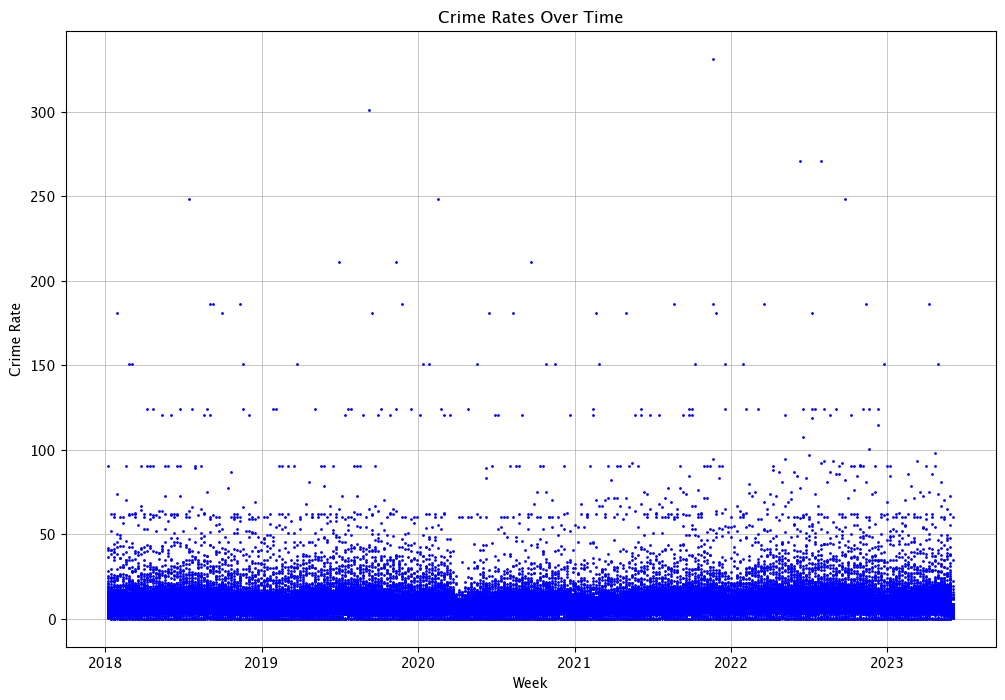

In [20]:
df_plot = merged_df
df_plot.set_index('week', inplace=True)
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

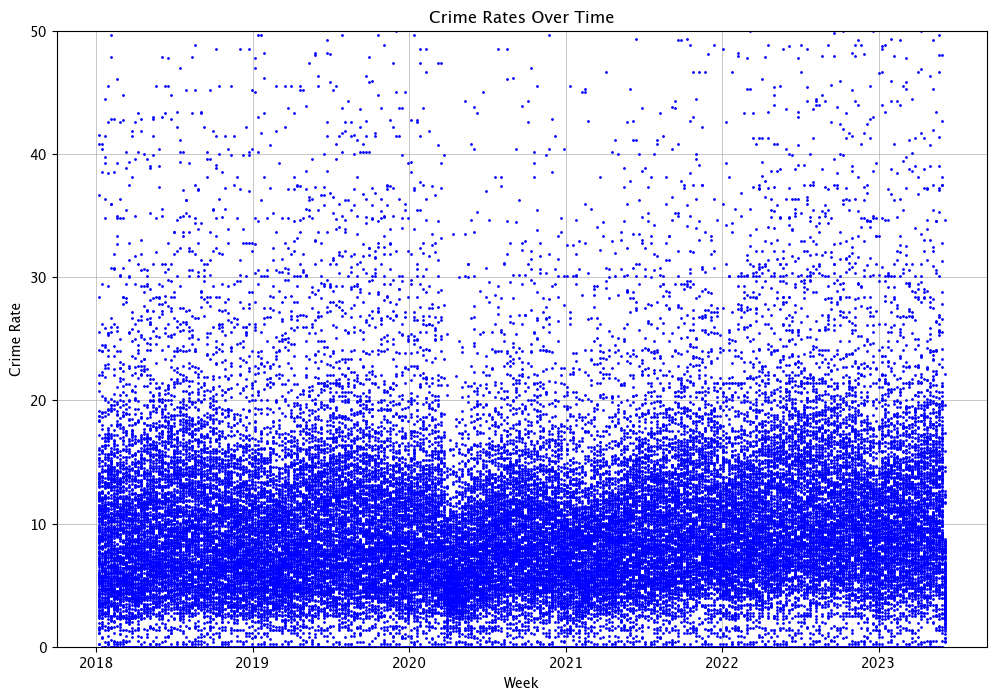

In [21]:
# zoom in
plt.figure(figsize=(12, 8))
plt.plot(df_plot.index, df_plot['crime_rate'], marker='o', linestyle='None', color='b', markersize=1)

plt.ylim(0, 50)

plt.title('Crime Rates Over Time')
plt.xlabel('Week')
plt.ylabel('Crime Rate')
plt.grid(True, linewidth=0.5)
plt.show()

In [22]:
statistics = merged_df.describe().T
print(statistics)

                    count          mean           std    min           25%  \
total_count       52050.0     48.146513     36.766557    0.0     19.000000   
total_population  52050.0  47178.536926  27050.788475  161.0  27083.000000   
crime_rate        52050.0     10.992952     10.964061    0.0      5.857323   

                           50%           75%            max  
total_count          40.000000     71.000000     243.000000  
total_population  42792.000000  68182.000000  112750.000000  
crime_rate            8.978258     13.052802     331.325301  


In [23]:
print(merged_df['total_count'].median())
print(merged_df['total_population'].median())
print(merged_df['crime_rate'].median())

40.0
42792.0
8.978258185869816


# S2301 Employment

https://data.census.gov/table/ACSST5Y2022.S2301?g=160XX00US3651000$8600000

In [24]:
crime = merged_df.reset_index()
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate
0,2018-01-07,10001,99,27004,36.661235
1,2018-01-14,10001,104,27004,38.512813
2,2018-01-21,10001,120,27004,44.437861
3,2018-01-28,10001,123,27004,45.548808
4,2018-02-04,10001,97,27004,35.920604


In [25]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S2301.csv'
df = pd.read_csv(file_path, low_memory=False)
employment = df[['NAME', 'S2301_C03_001E', 'S2301_C04_001E']]
employment = employment.iloc[1:].reset_index(drop=True)
employment.columns = ['ZCTA5CE10', 'e/pop_rate', 'un_rate']
employment['ZCTA5CE10'] = employment['ZCTA5CE10'].str.replace('ZCTA5 ', '')
employment.head()

,ZCTA5CE10,e/pop_rate,un_rate
0,10001,69.5,4.3
1,10002,51.0,7.6
2,10003,64.3,4.7
3,10004,83.6,0.4
4,10005,91.7,3.4


In [26]:
crime = crime.merge(employment, on = 'ZCTA5CE10', how = 'right')
crime.tail()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate
52076,2023-04-23,11697,0.0,3946.0,0.000000,54.6,3.4
52077,2023-04-30,11697,0.0,3946.0,0.000000,54.6,3.4
52078,2023-05-07,11697,1.0,3946.0,2.534212,54.6,3.4
52079,2023-05-14,11697,1.0,3946.0,2.534212,54.6,3.4
52080,2023-05-21,11697,1.0,3946.0,2.534212,54.6,3.4


# S1701 poverty

https://data.census.gov/table/ACSST5Y2022.S1701?g=160XX00US3651000$8600000

In [27]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S1701.csv'
df = pd.read_csv(file_path, low_memory=False)
poverty = df[['NAME', 'S1701_C03_001E']]
poverty = poverty.iloc[1:].reset_index(drop=True)
poverty.columns = ['ZCTA5CE10', 'p_rate']
poverty['ZCTA5CE10'] = poverty['ZCTA5CE10'].str.replace('ZCTA5 ', '')
poverty.head()

,ZCTA5CE10,p_rate
0,10001,15.9
1,10002,26.1
2,10003,12.1
3,10004,3.1
4,10005,5.2


In [28]:
crime = crime.merge(poverty, on = 'ZCTA5CE10', how = 'outer')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate
0,2018-01-07,10001,99.0,27004.0,36.661235,69.5,4.3,15.9
1,2018-01-14,10001,104.0,27004.0,38.512813,69.5,4.3,15.9
2,2018-01-21,10001,120.0,27004.0,44.437861,69.5,4.3,15.9
3,2018-01-28,10001,123.0,27004.0,45.548808,69.5,4.3,15.9
4,2018-02-04,10001,97.0,27004.0,35.920604,69.5,4.3,15.9


# S1901 Household Income 

https://data.census.gov/table/ACSST5Y2022.S1901?g=160XX00US3651000$8600000

In [29]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_ACSST5Y2022S1901.csv'
df = pd.read_csv(file_path, low_memory=False)
HI = df[['NAME', 'S1901_C01_012E', 'S1901_C01_013E']]
HI = HI.iloc[1:].reset_index(drop=True)
HI.columns = ['ZCTA5CE10', 'in_median', 'in_mean']
HI['ZCTA5CE10'] = HI['ZCTA5CE10'].str.replace('ZCTA5 ', '')
HI.head()

,ZCTA5CE10,in_median,in_mean
0,10001,106509,176483
1,10002,43362,86843
2,10003,152863,250384
3,10004,232543,342833
4,10005,189886,251095


In [30]:
crime = crime.merge(HI, on = 'ZCTA5CE10', how = 'outer')
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean
0,2018-01-07,10001,99.0,27004.0,36.661235,69.5,4.3,15.9,106509,176483
1,2018-01-14,10001,104.0,27004.0,38.512813,69.5,4.3,15.9,106509,176483
2,2018-01-21,10001,120.0,27004.0,44.437861,69.5,4.3,15.9,106509,176483
3,2018-01-28,10001,123.0,27004.0,45.548808,69.5,4.3,15.9,106509,176483
4,2018-02-04,10001,97.0,27004.0,35.920604,69.5,4.3,15.9,106509,176483


# Covid

case rate per 100,000: https://github.com/nychealth/coronavirus-data/blob/master/trends/caserate-by-modzcta.csv

In [31]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/nyc_caserate-by-modzcta.csv'
caserate = pd.read_csv(file_path, low_memory=False)

In [32]:
caserate = caserate.drop(columns=["CASERATE_CITY", "CASERATE_BX", "CASERATE_BK", "CASERATE_MN", "CASERATE_QN", "CASERATE_SI"])
caserate = caserate.rename(columns={"week_ending": "week"})
caserate.head()

,week,CASERATE_10001,CASERATE_10002,CASERATE_10003,CASERATE_10004,CASERATE_10005,CASERATE_10006,CASERATE_10007,CASERATE_10009,CASERATE_10010,...,CASERATE_11432,CASERATE_11433,CASERATE_11434,CASERATE_11435,CASERATE_11436,CASERATE_11691,CASERATE_11692,CASERATE_11693,CASERATE_11694,CASERATE_11697
0,08/08/2020,7.24,39.83,7.41,0.00,22.84,0.00,14.3,19.25,20.99,...,23.04,19.17,8.99,20.54,9.98,32.91,28.53,0.00,24.06,58.95
1,08/15/2020,14.49,10.62,7.41,0.00,57.10,0.00,14.3,8.75,38.98,...,42.80,32.86,16.48,23.97,9.98,22.44,28.53,7.89,19.25,0.00
2,08/22/2020,14.49,21.24,18.53,33.65,34.26,0.00,0.0,17.50,20.99,...,32.92,16.43,13.48,20.54,9.98,38.89,19.02,0.00,33.69,29.48
3,08/29/2020,7.24,10.62,20.38,0.00,22.84,59.14,14.3,12.25,26.98,...,19.75,13.69,16.48,20.54,9.98,62.82,4.76,15.78,14.44,29.48
4,09/05/2020,32.59,7.97,20.38,67.29,45.68,147.85,14.3,14.00,14.99,...,13.17,16.43,11.98,22.25,9.98,50.86,14.27,7.89,14.44,88.43


In [33]:
caserate = caserate.melt(id_vars=["week"], 
                  var_name="ZCTA5CE10", 
                  value_name="CASERATE")

caserate["ZCTA5CE10"] = caserate["ZCTA5CE10"].str.replace("CASERATE_", "")

caserate['week'] = pd.to_datetime(caserate['week'], errors='coerce')
caserate = caserate[(caserate['week'] >= pd.Timestamp('2018-01-01')) & (caserate['week'] <= pd.Timestamp('2023-05-31'))]
caserate['CASERATE'] = caserate['CASERATE'] * 10

In [34]:
caserate.head()

,week,ZCTA5CE10,CASERATE
0,2020-08-08,10001,72.4
1,2020-08-15,10001,144.9
2,2020-08-22,10001,144.9
3,2020-08-29,10001,72.4
4,2020-09-05,10001,325.9


hospitalization rate  https://github.com/nychealth/coronavirus-data/blob/master/trends/hosprate-by-modzcta.csv

In [35]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/nyc_hosprate-by-modzcta.csv'
hosprate = pd.read_csv(file_path, low_memory=False)
hosprate.head()

,date,HOSPRATE_Bronx,HOSPRATE_Brooklyn,HOSPRATE_Manhattan,HOSPRATE_Queens,HOSPRATE_Staten_Island,HOSPRATE_Citywide,HOSPRATE_10001,HOSPRATE_10002,HOSPRATE_10003,...,HOSPRATE_11432,HOSPRATE_11433,HOSPRATE_11434,HOSPRATE_11435,HOSPRATE_11436,HOSPRATE_11691,HOSPRATE_11692,HOSPRATE_11693,HOSPRATE_11694,HOSPRATE_11697
0,3/2020,267.2,206.8,166.6,265.9,156.9,222.3,54.3,224.4,83.4,...,279.8,287.5,310.1,260.2,244.5,342.5,337.6,284.1,192.5,NaN
1,4/2020,436.7,300.4,235.5,394.3,264.2,334.3,184.7,282.8,105.6,...,429.6,438.1,405.9,412.6,309.3,767.3,565.9,244.6,596.7,235.8
2,5/2020,66.4,45.4,33.3,47.4,48.3,47.3,50.7,41.2,11.1,...,79.0,43.8,49.4,44.5,44.9,97.2,90.4,NaN,57.7,NaN
3,6/2020,22.2,21.4,12.5,18.3,11.6,18.4,NaN,13.3,NaN,...,24.7,21.9,15.0,24.0,NaN,31.4,23.8,NaN,NaN,NaN
4,7/2020,18.5,14.0,10.7,13.5,11.6,13.9,NaN,17.3,NaN,...,13.2,27.4,9.0,10.3,34.9,12.0,NaN,NaN,NaN,NaN


percent positivehttps://github.com/nychealth/coronavirus-data/blob/master/trends/percentpositive-by-modzcta.csv
         what is pctpos https://publichealth.jhu.edu/2020/covid-19-testing-understanding-the-percent-positive

In [36]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/nyc_percentpositive-by-modzcta.csv'
pctpos = pd.read_csv(file_path, low_memory=False)
pctpos = pctpos.drop(columns=["PCTPOS_CITY", "PCTPOS_BX", "PCTPOS_BK", "PCTPOS_MN", "PCTPOS_QN", "PCTPOS_SI"])
pctpos = pctpos.rename(columns={"week_ending": "week"})
pctpos.head()

,week,PCTPOS_10001,PCTPOS_10002,PCTPOS_10003,PCTPOS_10004,PCTPOS_10005,PCTPOS_10006,PCTPOS_10007,PCTPOS_10009,PCTPOS_10010,...,PCTPOS_11432,PCTPOS_11433,PCTPOS_11434,PCTPOS_11435,PCTPOS_11436,PCTPOS_11691,PCTPOS_11692,PCTPOS_11693,PCTPOS_11694,PCTPOS_11697
0,08/08/2020,0.74,1.94,0.26,0.00,2.89,0.00,1.11,0.61,1.18,...,2.03,1.46,0.71,1.38,0.86,1.61,1.41,0.85,1.42,2.47
1,08/15/2020,0.92,0.57,0.17,0.00,2.21,1.37,0.88,0.53,2.04,...,2.91,2.57,0.77,1.53,1.20,1.14,1.31,0.85,0.94,0.00
2,08/22/2020,0.36,1.03,0.26,1.11,0.98,0.00,0.54,0.58,0.49,...,1.63,1.14,0.99,1.57,0.84,1.30,0.14,0.00,2.64,1.05
3,08/29/2020,0.52,0.44,0.34,0.00,1.65,2.25,0.39,0.61,0.97,...,1.20,0.86,1.07,1.19,0.80,2.07,0.53,0.81,0.93,1.14
4,09/05/2020,1.03,0.53,0.39,1.79,1.65,3.67,0.31,0.43,0.55,...,1.43,0.87,0.57,1.29,0.48,1.84,0.59,0.38,0.96,3.33


In [37]:
pctpos = pctpos.melt(id_vars=["week"], 
                  var_name="ZCTA5CE10", 
                  value_name="PCTPOS")

pctpos["ZCTA5CE10"] = pctpos["ZCTA5CE10"].str.replace("PCTPOS_", "")

pctpos['week'] = pd.to_datetime(pctpos['week'], errors='coerce')
pctpos = pctpos[(pctpos['week'] >= pd.Timestamp('2018-01-01')) & (pctpos['week'] <= pd.Timestamp('2023-05-31'))]
pctpos.head()

,week,ZCTA5CE10,PCTPOS
0,2020-08-08,10001,0.74
1,2020-08-15,10001,0.92
2,2020-08-22,10001,0.36
3,2020-08-29,10001,0.52
4,2020-09-05,10001,1.03


In [38]:
covid = pd.merge(caserate, pctpos, on=["week", "ZCTA5CE10"])
covid['week'] = covid['week'] + pd.Timedelta(days=1) #correspond to crime data
covid.tail()

,week,ZCTA5CE10,CASERATE,PCTPOS
25837,2023-04-23,11697,0.0,0.00
25838,2023-04-30,11697,294.8,3.70
25839,2023-05-07,11697,0.0,0.00
25840,2023-05-14,11697,294.8,3.13
25841,2023-05-21,11697,0.0,0.00


# Regression

In [39]:
crime = pd.merge(crime, covid, on=["week", "ZCTA5CE10"], how="left")

In [40]:
crime["CASERATE"].fillna(0, inplace=True)
crime["PCTPOS"].fillna(0, inplace=True)

In [41]:
min_date = crime['week'].min()
crime['week_no'] = ((crime['week'] - min_date).dt.days // 7) + 1

In [42]:
crime.tail(200)

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean,CASERATE,PCTPOS,week_no
51881,2019-07-28,11697,0.0,3946.0,0.000000,54.6,3.4,3.9,134563,160188,0.0,0.00,82.0
51882,2019-08-04,11697,1.0,3946.0,2.534212,54.6,3.4,3.9,134563,160188,0.0,0.00,83.0
51883,2019-08-11,11697,0.0,3946.0,0.000000,54.6,3.4,3.9,134563,160188,0.0,0.00,84.0
51884,2019-08-18,11697,1.0,3946.0,2.534212,54.6,3.4,3.9,134563,160188,0.0,0.00,85.0
51885,2019-08-25,11697,0.0,3946.0,0.000000,54.6,3.4,3.9,134563,160188,0.0,0.00,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52076,2023-04-23,11697,0.0,3946.0,0.000000,54.6,3.4,3.9,134563,160188,0.0,0.00,277.0
52077,2023-04-30,11697,0.0,3946.0,0.000000,54.6,3.4,3.9,134563,160188,294.8,3.70,278.0
52078,2023-05-07,11697,1.0,3946.0,2.534212,54.6,3.4,3.9,134563,160188,0.0,0.00,279.0
52079,2023-05-14,11697,1.0,3946.0,2.534212,54.6,3.4,3.9,134563,160188,294.8,3.13,280.0


In [43]:
crime.to_csv('nyc_weekly_data.csv', index=False)

In [44]:
crime['in_median'] = crime['in_median'].astype(str)
crime['in_median'] = crime['in_median'].replace('250,000+', '250000')
crime['week_no'] = pd.to_numeric(crime['week_no'], errors='coerce')
crime['p_rate'] = crime['p_rate'].replace('-', np.nan).astype(float)
crime['un_rate'] = crime['un_rate'].replace('-', np.nan).astype(float)
crime['in_median'] = crime['in_median'].replace('-', np.nan).astype(float)
crime['crime_rate'] = crime['crime_rate'].replace('-', np.nan).astype(float)

crime.dropna(subset=['p_rate', 'un_rate', 'in_median', 'crime_rate'], inplace=True)

X = crime[['week_no', 'p_rate', 'un_rate', 'in_median', 'CASERATE', 'PCTPOS']] 
Y = crime['crime_rate']

model = sm.OLS(Y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             crime_rate   R-squared (uncentered):                   0.635
Model:                            OLS   Adj. R-squared (uncentered):              0.635
Method:                 Least Squares   F-statistic:                          1.502e+04
Date:                Thu, 29 Feb 2024   Prob (F-statistic):                        0.00
Time:                        21:09:21   Log-Likelihood:                     -1.8425e+05
No. Observations:               51767   AIC:                                  3.685e+05
Df Residuals:                   51761   BIC:                                  3.686e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [45]:
crime['y_hat'] = model.predict(X)

In [46]:
crime.head()

,week,ZCTA5CE10,total_count,total_population,crime_rate,e/pop_rate,un_rate,p_rate,in_median,in_mean,CASERATE,PCTPOS,week_no,y_hat
0,2018-01-07,10001,99.0,27004.0,36.661235,69.5,4.3,15.9,106509.0,176483,0.0,0.0,1.0,13.264941
1,2018-01-14,10001,104.0,27004.0,38.512813,69.5,4.3,15.9,106509.0,176483,0.0,0.0,2.0,13.264587
2,2018-01-21,10001,120.0,27004.0,44.437861,69.5,4.3,15.9,106509.0,176483,0.0,0.0,3.0,13.264232
3,2018-01-28,10001,123.0,27004.0,45.548808,69.5,4.3,15.9,106509.0,176483,0.0,0.0,4.0,13.263878
4,2018-02-04,10001,97.0,27004.0,35.920604,69.5,4.3,15.9,106509.0,176483,0.0,0.0,5.0,13.263524


# 2020 Population

Population 2020 https://data.census.gov/table/DECENNIALDHC2020.P1?g=160XX00US3651000$8600000

In [ ]:
file_path = '/Users/yokij/Desktop/Capstone/NYC/NYC_DECENNIALDHC2020.csv'
pop = pd.read_csv(file_path, low_memory=False)
# Set the header row as the df header
pop_transposed = pop.transpose()
pop_transposed = pop_transposed.reset_index()
new_header = pop_transposed.iloc[0]  
pop_transposed = pop_transposed[1:]  
pop_transposed.columns = new_header  
pop = pop_transposed.rename(columns={"Label (Grouping)": "ZCTA5CE10"})
pop['ZCTA5CE10'] = pop['ZCTA5CE10'].str.replace('ZCTA5 ', '')
pop = pop.iloc[:, [0, 1]]  
pop.head()
crime = pd.merge(weekly_geodata, pop, on='ZCTA5CE10', how='left')
crime.head()
crime['Total'] = pd.to_numeric(crime['Total'].str.replace(',', ''), errors='coerce').fillna(0).astype(int)
crime['crime_rate'] = (crime['total_count'] / crime['Total']) * 10000
crime = crime.rename(columns={'Total': "total_population"})
crime = crime.rename(columns={"CMPLNT_FR_DT": "week"})
crime = crime[crime['total_population'] != 0]